# Train and get Hex2Vec embedding

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

d:\hex2vec2


## Load training data
We first load the data we downloaded in the notebook `load-osm.ipynb` into a dataframe (`df`). We can specify which tags and columns we want to use.

In [3]:
from src.data.load_data import load_processed_dataset
import pandas as pd
from src.settings import DATA_PROCESSED_DIR, DATA_BRW


In [4]:
RESOLUTION = 9

In [28]:
# load data from DATA_PROCESSED_DIR
df = load_processed_dataset(RESOLUTION)

# remove columns that are not used
not_used_columns = df.columns[df.sum() == 0]
df = df.drop(columns=not_used_columns)

# remove hexagons that do not contain any object
df = df[~(df.drop(columns='city') == 0).all(axis=1)]

# remove duplicates (these exist because some hexagons are assigned to two neighbouring cities)
df = df[~df.index.duplicated(keep="first")]

In [29]:
# here we define dataframes with specific hexagons: urban (no forest, farmland or water) and brw (hexagons we know the brw of)
# these dataframes contain hexagons from the 10 biggest cities in NRW
urban_indices = pd.read_feather(DATA_PROCESSED_DIR.joinpath("urban_indices.feather"))
brw_indices = pd.read_feather(DATA_BRW.joinpath("concat.feather")).index

df_urban = df.loc[urban_indices.indices]
df_brw = df.loc[brw_indices]

## Visualize data distribution
Before we start training we are having a look at how many tags are in each hexagon

In [7]:
from src.data.make_dataset import h3_to_polygon
from src.analytics.visualization import plot_map

In [8]:
vis_df = df.copy(deep=False)
vis_df['geometry'] = vis_df.index.map(h3_to_polygon)
vis_df['sum_of_tags'] = df.sum(axis=1, numeric_only=True).values

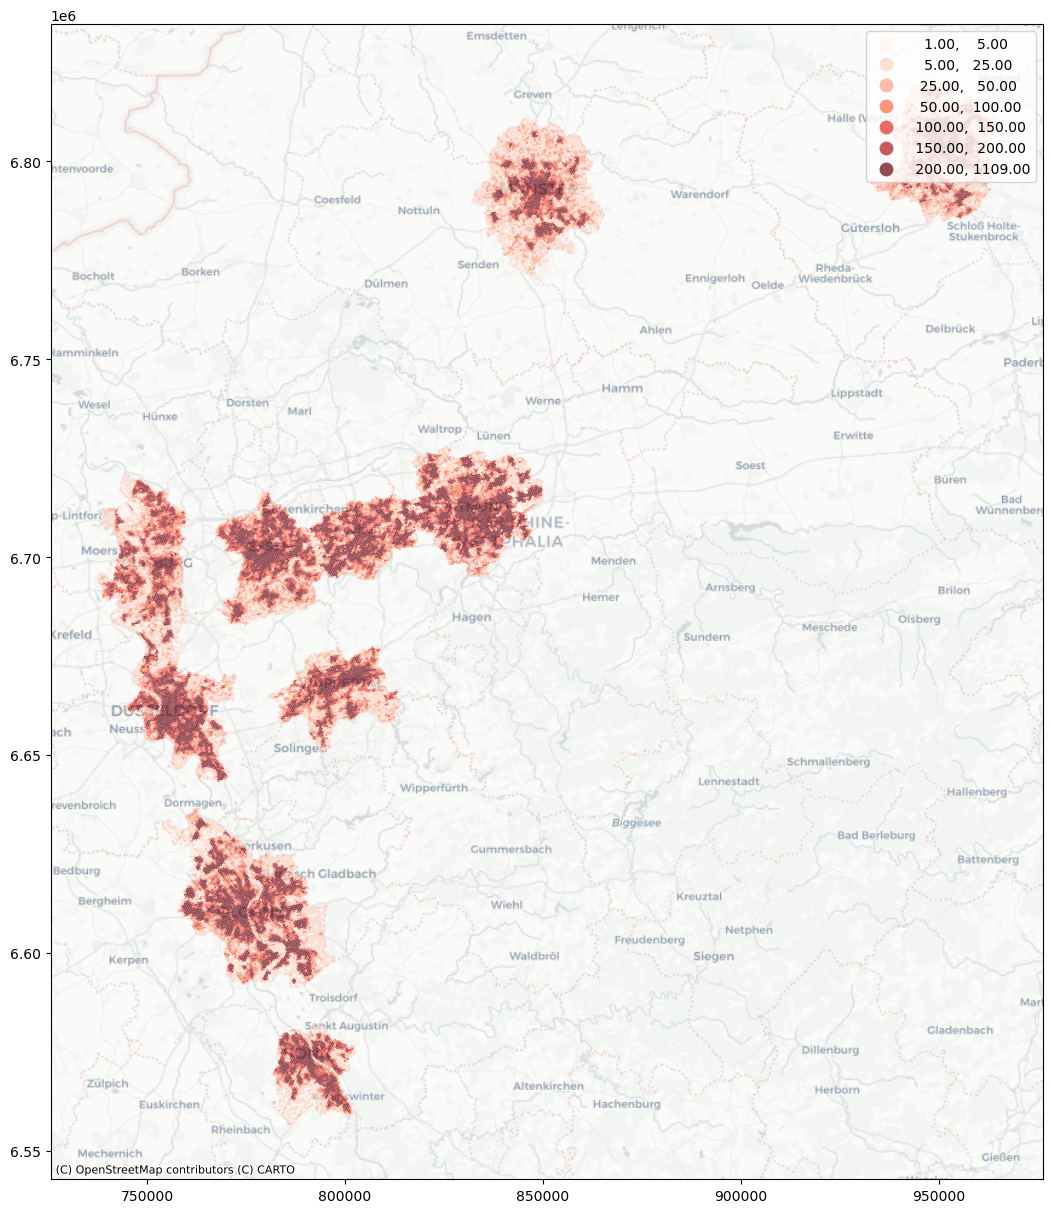

In [9]:
plot_map(vis_df, "sum_of_tags", bins = [5, 25, 50, 100, 150, 200], colors="Reds")

## Build training data set
Our training data set (inherits from pytorch Dataset) provides us for every hexagon with a neighbour and a random other (not neighbouring) hexagon. In `H3NeighborDataset` this is a random hexagon from any city and in `H3NeighborDataset2` this hexagon is from the same city.

In [10]:
from src.models.h3_neighbor_dataset import H3NeighborDataset2, H3NeighborDataset

In [34]:
train_dataset = H3NeighborDataset2(df.drop(columns='year'))
# train_dataset = H3NeighborDataset(df.drop(columns=['year', 'city']))

100%|██████████| 18251/18251 [00:09<00:00, 1857.43it/s]


## Training
Here we define the model and perform the actual training. Our model `BinaryNN` inherits from pytorch Lightningmodule.

In [31]:
from torch.utils.data import DataLoader
from src.models.binary_nn import BinaryNN
from lightning.pytorch import seed_everything, Trainer

In [ ]:
# set seed for reproducibility
SEED = 42
seed_everything(SEED)

# set hyperparameter
data_shape = train_dataset.data_torch.shape[1]
batch_size = 512
epochs = 100
sizes = [150, 75, 50]

# set data, trainer and model
trainer = Trainer(max_epochs=epochs)
model = BinaryNN([data_shape, *sizes])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
trainer.fit(model, train_dataloader, ckpt_path = "last")

## Embed data and save embedding for visualization
After training we use the Hex2Vec autoencoder one more time to get our final embedding. We then save both our original dataframe and the embedding to `DATA_EMBEDDED_DIR`.

In [18]:
from src.settings import DATA_EMBEDDED_DIR
import torch

In [37]:
# embed data with model
embedded = model.encoder(torch.Tensor(df.drop(columns=['city', 'year']).to_numpy())).detach().numpy()

# index with hex index
embedded_df = pd.DataFrame(embedded)
embedded_df.index = df.index
embedded_df.columns = embedded_df.columns.astype(str)

In [44]:
embedded_df.reset_index().to_feather(DATA_EMBEDDED_DIR.joinpath("embedded"))
df_brw.reset_index().to_feather(DATA_EMBEDDED_DIR.joinpath("df"))

## Most influential tags
Do get a better understanding of our embedding, we have a look at which tags play a bigger role in the embedding. I only looked at urban hexagons (`df_urban`) here.
First we will look at what tags had the biggest influence on each hexagon and then we concentrate on the influence of objects that we associate with a high quality of life in a city such as restaurants, bars or shops.

In [20]:
from src.analytics.analytics import find_important_tags, tag_importance_df, find_sim_group

In [38]:
df_urban_values = df_urban.drop(columns = ["city", "year"])
all_tags = df_urban_values.columns
median = df_urban_values.median()

In [39]:
# here we find the top 5 most influential tags for each hexagon
top_tags = find_important_tags(df_urban_values, model, all_tags, median, nr_top_tags=5)

In [40]:
top_tags.head()

,0,1,2,3,4
h3,,,,,
891f12591d3ffff,landuse_residential,building_house,landuse_meadow,building_yes,landuse_industrial
891fa11a007ffff,building_yes,landuse_farmland,building_garage,residential,landuse_forest
891f125b3c3ffff,building_yes,landuse_industrial,landuse_residential,building_garage,landuse_commercial
891fa52058bffff,landuse_farmland,building_yes,highway_footway,residential,track
891f12cf40bffff,landuse_industrial,residential,track,building_yes,landuse_residential


In [42]:
# from the top_tags-Dataframe we make a dataframe that has a columns for every tag and indicates the position
# of each tag in the top 5 (and None if its not in the top 5) for each hexagon. This is easier to handle for visualization
df_urban_tag_influence = tag_importance_df(all_tags, top_tags)

In [44]:
df_urban_tag_influence.head()

,aeroway_aerodrome,aeroway_apron,aeroway_gate,aeroway_helipad,aeroway_heliport,aeroway_navigationaid,aeroway_runway,aeroway_taxiway,aeroway_terminal,aeroway_windsock,...,water_point,government,toilets,retail,monastery,college,ice_cream,river,scuba_diving,military
h3,,,,,,,,,,,,,,,,,,,,,
891f12591d3ffff,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
891fa11a007ffff,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
891f125b3c3ffff,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
891fa52058bffff,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
891f12cf40bffff,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [45]:
# now we look at the influence of the following groups
shops = ["shop_clothes", "shop_shoes", "shop_boutique", "shop_books", "shop_sports", "shop_interior_decoration", "shop_perfumery", "shop_cosmetics", "shop_watches", "shop_jewelry", "shop_fashion_accessories"]
bars = ["amenity_bar", "amenity_pub", "amenity_nightclub"]
restaurants = ["amenity_restaurant", "amenity_biergarten", "amenity_cafe", "ice_cream", "amenity_fast_food"]

In [ ]:
# find_sim_groups returns the cosine similarity between each hexagon and the same hexagon but with the median
# value in the specified tags. A low value meand great influence
df_urban["shops"] = find_sim_group(df_urban_values, model, shops, median)
df_urban["food"] = find_sim_group(df_urban_values, model, restaurants, median)
df_urban["drink"] = find_sim_group(df_urban_values, model, bars, median)

In [144]:
# Now we mark those hexagons with a certain influence of those groups
df_urban["shops_influence"] = df_urban.shops[(df_urban.shops < 0.99)]
df_urban["drink_influence"] = df_urban.drink[(df_urban.drink < 0.999)]
df_urban["food_influence"] = df_urban.food[((df_urban.food < 0.98))]